In [1]:
# imports

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
sys.path.append('../')
import plotting.plottools
importlib.reload(plotting.plottools)
from plotting.plottools import plot_histogram
import preprocessor
importlib.reload(preprocessor)
from preprocessor import PreProcessor

In [2]:
# get some example histograms

fname = '../data/examples/ZeroBias-Run2023C-PromptReco-v1-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1.parquet'
omsfile = 'omsdata/omsdata_Run2023C-v1.json'
df = pd.read_parquet(fname)
xbins = df['Xbins'][0]
ybins = df['Ybins'][0]
nhists = 3
hists = np.array([df['histo'][i].reshape(xbins,ybins) for i in range(nhists)])
runs = np.array([df['fromrun'][i] for i in range(nhists)])
lumis = np.array([df['fromlumi'][i] for i in range(nhists)])
print('Shape of hists array: {}'.format(hists.shape))
print('Runs: {}'.format(runs))
print('Lumis: {}'.format(lumis))

Shape of hists array: (3, 200, 200)
Runs: [367129 367129 367129]
Lumis: [1 2 3]


In [3]:
# make a PreProcessor

prep = PreProcessor(
    crop=(slice(20,180), slice(19,179)), # heuristic, turns out to work, but not clear why
    time_average_radii={0:2, 50:5},
    rebin_target=(20,20),
    omsjson=omsfile,
    oms_normalization_attr='pileup'
)
print(prep)

PreProcessor instance with following attributes:
 - crop: (slice(20, 180, None), slice(19, 179, None))
 - time_average_radii: {0: 2, 50: 5}
 - rebin_target: (20, 20)
 - omsjson: <loaded>
 - oms_normalization_attr: pileup
 - spatial_normalization: None


In [4]:
# do preprocessing

preprocessed_hists = prep.preprocess(hists, runs, lumis)

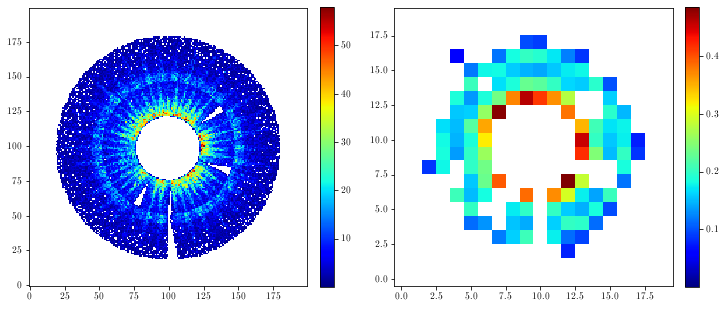

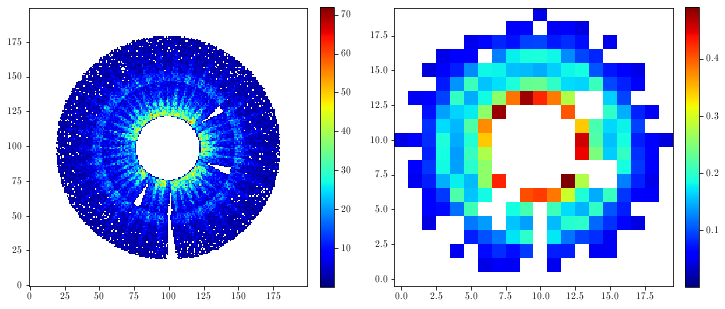

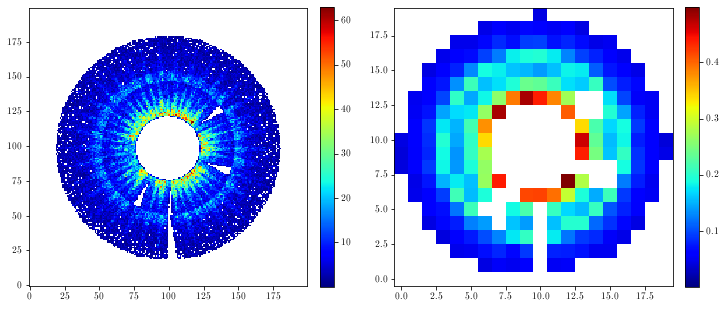

In [5]:
# plot raw and preprocessed histograms

for i in range(len(hists)):
    fig,axs = plt.subplots(figsize=(12,6), ncols=2)
    plot_histogram(hists[i], fig=fig, ax=axs[0])
    plot_histogram(preprocessed_hists[i], fig=fig, ax=axs[1])

In [9]:
# timing test with a larger file

import time
from pyarrow.parquet import ParquetFile
import pyarrow as pa

fname = '../data/data/ZeroBias-Run2023C-PromptReco-v1-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1.parquet'
omsfile = 'omsdata/omsdata_Run2023C-v1.json'

print('Loading data...')
starttime = time.time()
nhists = 500
pf = ParquetFile(fname) 
batch = next(pf.iter_batches(batch_size = nhists)) 
df = pa.Table.from_batches([batch]).to_pandas() 
xbins = df['Xbins'][0]
ybins = df['Ybins'][0]
hists = np.array([df['histo'][i].reshape(xbins,ybins) for i in range(nhists)])
runs = np.array(df['fromrun'])
lumis = np.array(df['fromlumi'])
print('Shape of hists array: {}'.format(hists.shape))

print('Preprocessing...')
pretime = time.time()
preprocessed_hists = prep.preprocess(hists, runs=runs, lumis=lumis)
posttime = time.time()

print('Timing report:')
print('Loading data: {:.3f} seconds'.format(pretime - starttime))
print('Preprocessing: {:.3f} seconds'.format(posttime - pretime))

Loading data...
Shape of hists array: (500, 200, 200)
Preprocessing...
WARNING in normalize_by_external: some normvalues are zero, will set zeros to one.
Timing report:
Loading data: 1.764 seconds
Preprocessing: 1.735 seconds


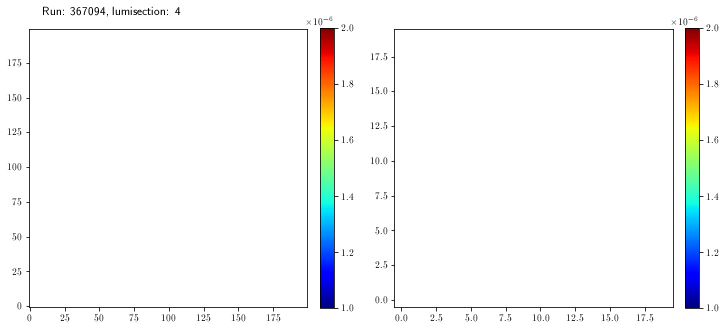

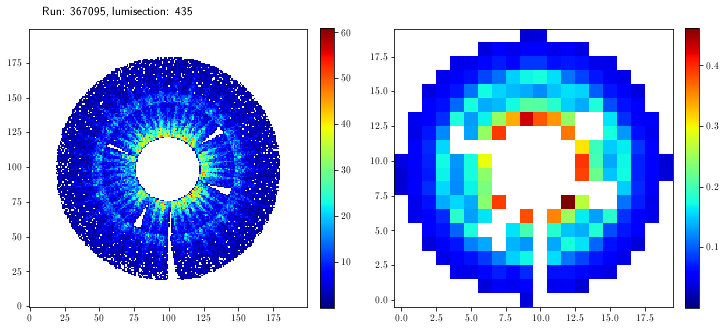

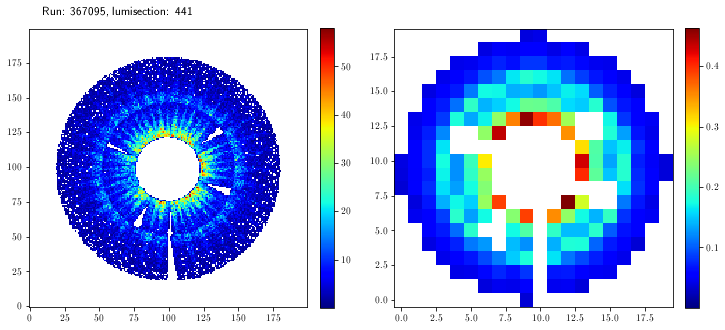

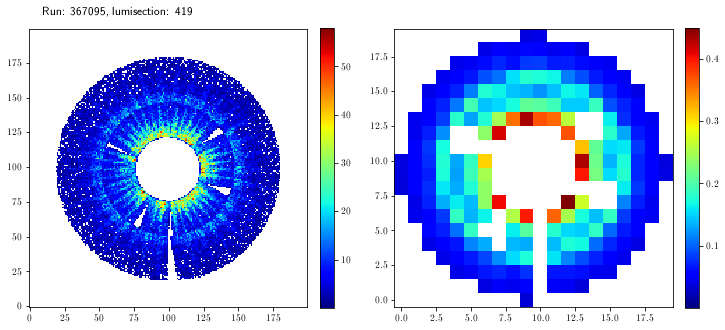

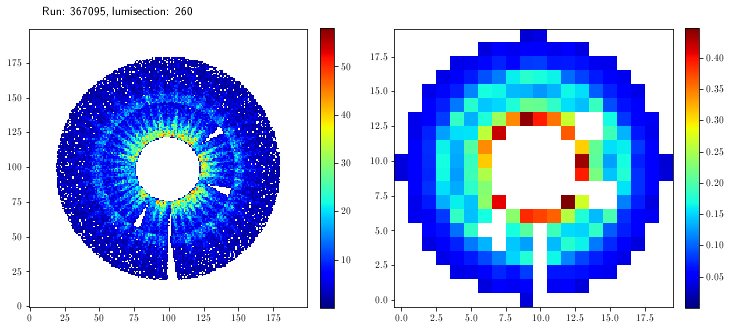

In [10]:
# plot some random examples

nplots = 5
random_indices = np.random.choice(nhists, size=nplots, replace=False)

for i in random_indices:
    
    fig,axs = plt.subplots(figsize=(12,6), ncols=2)
    plot_histogram(hists[i], fig=fig, ax=axs[0])
    axs[0].text(0.05, 1.05, 'Run: {}, lumisection: {}'.format(runs[i], lumis[i]), transform=axs[0].transAxes, fontsize=12)
    plot_histogram(preprocessed_hists[i], fig=fig, ax=axs[1])